# 1. Overview

This is a notebook for training models to submit predictions to the "Diabetes Prediction Challenge" Kaggle competition ([playground-series-s5e12](https://www.kaggle.com/competitions/playground-series-s5e12)).

Synthetic data is used for this playground competition, and the objective is to, for each patient in the test set, predict the probability that the patient will be diagnosed with diabetes.

# 2. Setup

## 2.1 Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import random
import warnings
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

pd.set_option('display.max_colwidth', None) # Display full column content
pd.set_option('display.max_rows', None) # Display all rows
pd.set_option('display.width', 1000) # Set larger display width

## 2.2 Reproducibility

For reproducibility of results, an arbitrary number will be used for the random seed.

In [2]:
RANDOM_SEED = 11
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## 2.3 DataFrames

Read the data provided for the competition into dataframes.

In [3]:
INPUT_DIR = '/kaggle/input'
orig_train_data = pd.read_csv(os.path.join(INPUT_DIR, 'playground-series-s5e12/train.csv'))
orig_test_data = pd.read_csv(os.path.join(INPUT_DIR, 'playground-series-s5e12/test.csv'))

# set index
orig_train_data.set_index('id', inplace=True)
orig_test_data.set_index('id', inplace=True)

# target column
target_col = "diagnosed_diabetes"

# 3. Exploratory Data Analysis

In [4]:
orig_train_data.describe()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
count,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000
mean,50.359734,2.072411,80.230803,5.963695,7.002200,6.012733,25.874684,0.858766,116.294193,75.440924,70.167749,186.818801,53.823214,102.905854,123.081850,0.149401,0.181990,0.030324,0.623296
std,11.655520,1.048189,51.195071,1.463336,0.901907,2.022707,2.860705,0.037980,11.010390,6.825775,6.938722,16.730832,8.266545,19.022416,24.739397,0.356484,0.385837,0.171478,0.484560
min,19.000000,1.000000,1.000000,0.100000,3.100000,0.600000,15.100000,0.680000,91.000000,51.000000,42.000000,117.000000,21.000000,51.000000,31.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,1.000000,49.000000,5.000000,6.400000,4.600000,23.900000,0.830000,108.000000,71.000000,65.000000,175.000000,48.000000,89.000000,106.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,2.000000,71.000000,6.000000,7.000000,6.000000,25.900000,0.860000,116.000000,75.000000,70.000000,187.000000,54.000000,103.000000,123.000000,0.000000,0.000000,0.000000,1.000000
75%,58.000000,3.000000,96.000000,7.000000,7.600000,7.400000,27.800000,0.880000,124.000000,80.000000,75.000000,199.000000,59.000000,116.000000,139.000000,0.000000,0.000000,0.000000,1.000000
max,89.000000,9.000000,747.000000,9.900000,9.900000,16.500000,38.400000,1.050000,163.000000,104.000000,101.000000,289.000000,90.000000,205.000000,290.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
orig_test_data.describe()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,50.432397,2.089693,92.349087,5.945838,6.997795,6.011278,25.881906,0.859007,116.374117,75.396013,70.048350,187.308620,53.813557,103.416083,123.538480,0.152920,0.184410,0.033110
std,11.938741,1.066214,62.187399,1.481068,0.914693,2.060472,2.894289,0.038523,11.252146,6.950340,7.090543,18.413053,8.398126,20.571855,28.965441,0.359911,0.387819,0.178924
min,19.000000,1.000000,1.000000,0.100000,3.100000,0.600000,15.100000,0.690000,91.000000,51.000000,42.000000,107.000000,22.000000,51.000000,31.000000,0.000000,0.000000,0.000000
25%,42.000000,1.000000,51.000000,5.000000,6.400000,4.600000,23.900000,0.830000,108.000000,71.000000,65.000000,174.000000,48.000000,89.000000,104.000000,0.000000,0.000000,0.000000
50%,50.000000,2.000000,77.000000,6.000000,7.000000,6.000000,25.900000,0.860000,116.000000,75.000000,70.000000,187.000000,54.000000,103.000000,123.000000,0.000000,0.000000,0.000000
75%,59.000000,3.000000,115.000000,7.000000,7.600000,7.400000,27.800000,0.890000,124.000000,80.000000,75.000000,200.000000,60.000000,117.000000,142.000000,0.000000,0.000000,0.000000
max,89.000000,9.000000,748.000000,9.900000,9.900000,15.900000,38.300000,1.050000,170.000000,104.000000,101.000000,285.000000,91.000000,226.000000,290.000000,1.000000,1.000000,1.000000


In [6]:
numeric_col_names = orig_train_data.select_dtypes(include='number').columns.to_series()
categorical_col_names = orig_train_data.select_dtypes(include='object').columns.to_series()
assert numeric_col_names.size + categorical_col_names.size == orig_train_data.shape[1]

# drop target column from numeric column names
numeric_col_names.drop(target_col, inplace=True)

In [7]:
for (dataset_name, dataset) in [('Train data', orig_train_data), ('Test data', orig_test_data)]:
    print(f"##### {dataset_name} missing values #####")
    print(dataset.isnull().sum())
    print()

##### Train data missing values #####
age                                   0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
smoking_status                        0
employment_status                     0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0
di

In [8]:
for (dataset_name, dataset) in [('Train data', orig_train_data), ('Test data', orig_test_data)]:
    print(f"##### {dataset_name} categorical cols unique values #####")
    for categorical_col_name in categorical_col_names:
        print(f"{categorical_col_name}:")
        print(dataset[categorical_col_name].unique())
    print()

##### Train data categorical cols unique values #####
gender:
['Female' 'Male' 'Other']
ethnicity:
['Hispanic' 'White' 'Asian' 'Black' 'Other']
education_level:
['Highschool' 'Graduate' 'Postgraduate' 'No formal']
income_level:
['Lower-Middle' 'Upper-Middle' 'Low' 'Middle' 'High']
smoking_status:
['Current' 'Never' 'Former']
employment_status:
['Employed' 'Retired' 'Student' 'Unemployed']

##### Test data categorical cols unique values #####
gender:
['Female' 'Male' 'Other']
ethnicity:
['White' 'Hispanic' 'Black' 'Asian' 'Other']
education_level:
['Highschool' 'Graduate' 'Postgraduate' 'No formal']
income_level:
['Middle' 'Low' 'Lower-Middle' 'Upper-Middle' 'High']
smoking_status:
['Former' 'Never' 'Current']
employment_status:
['Employed' 'Unemployed' 'Retired' 'Student']



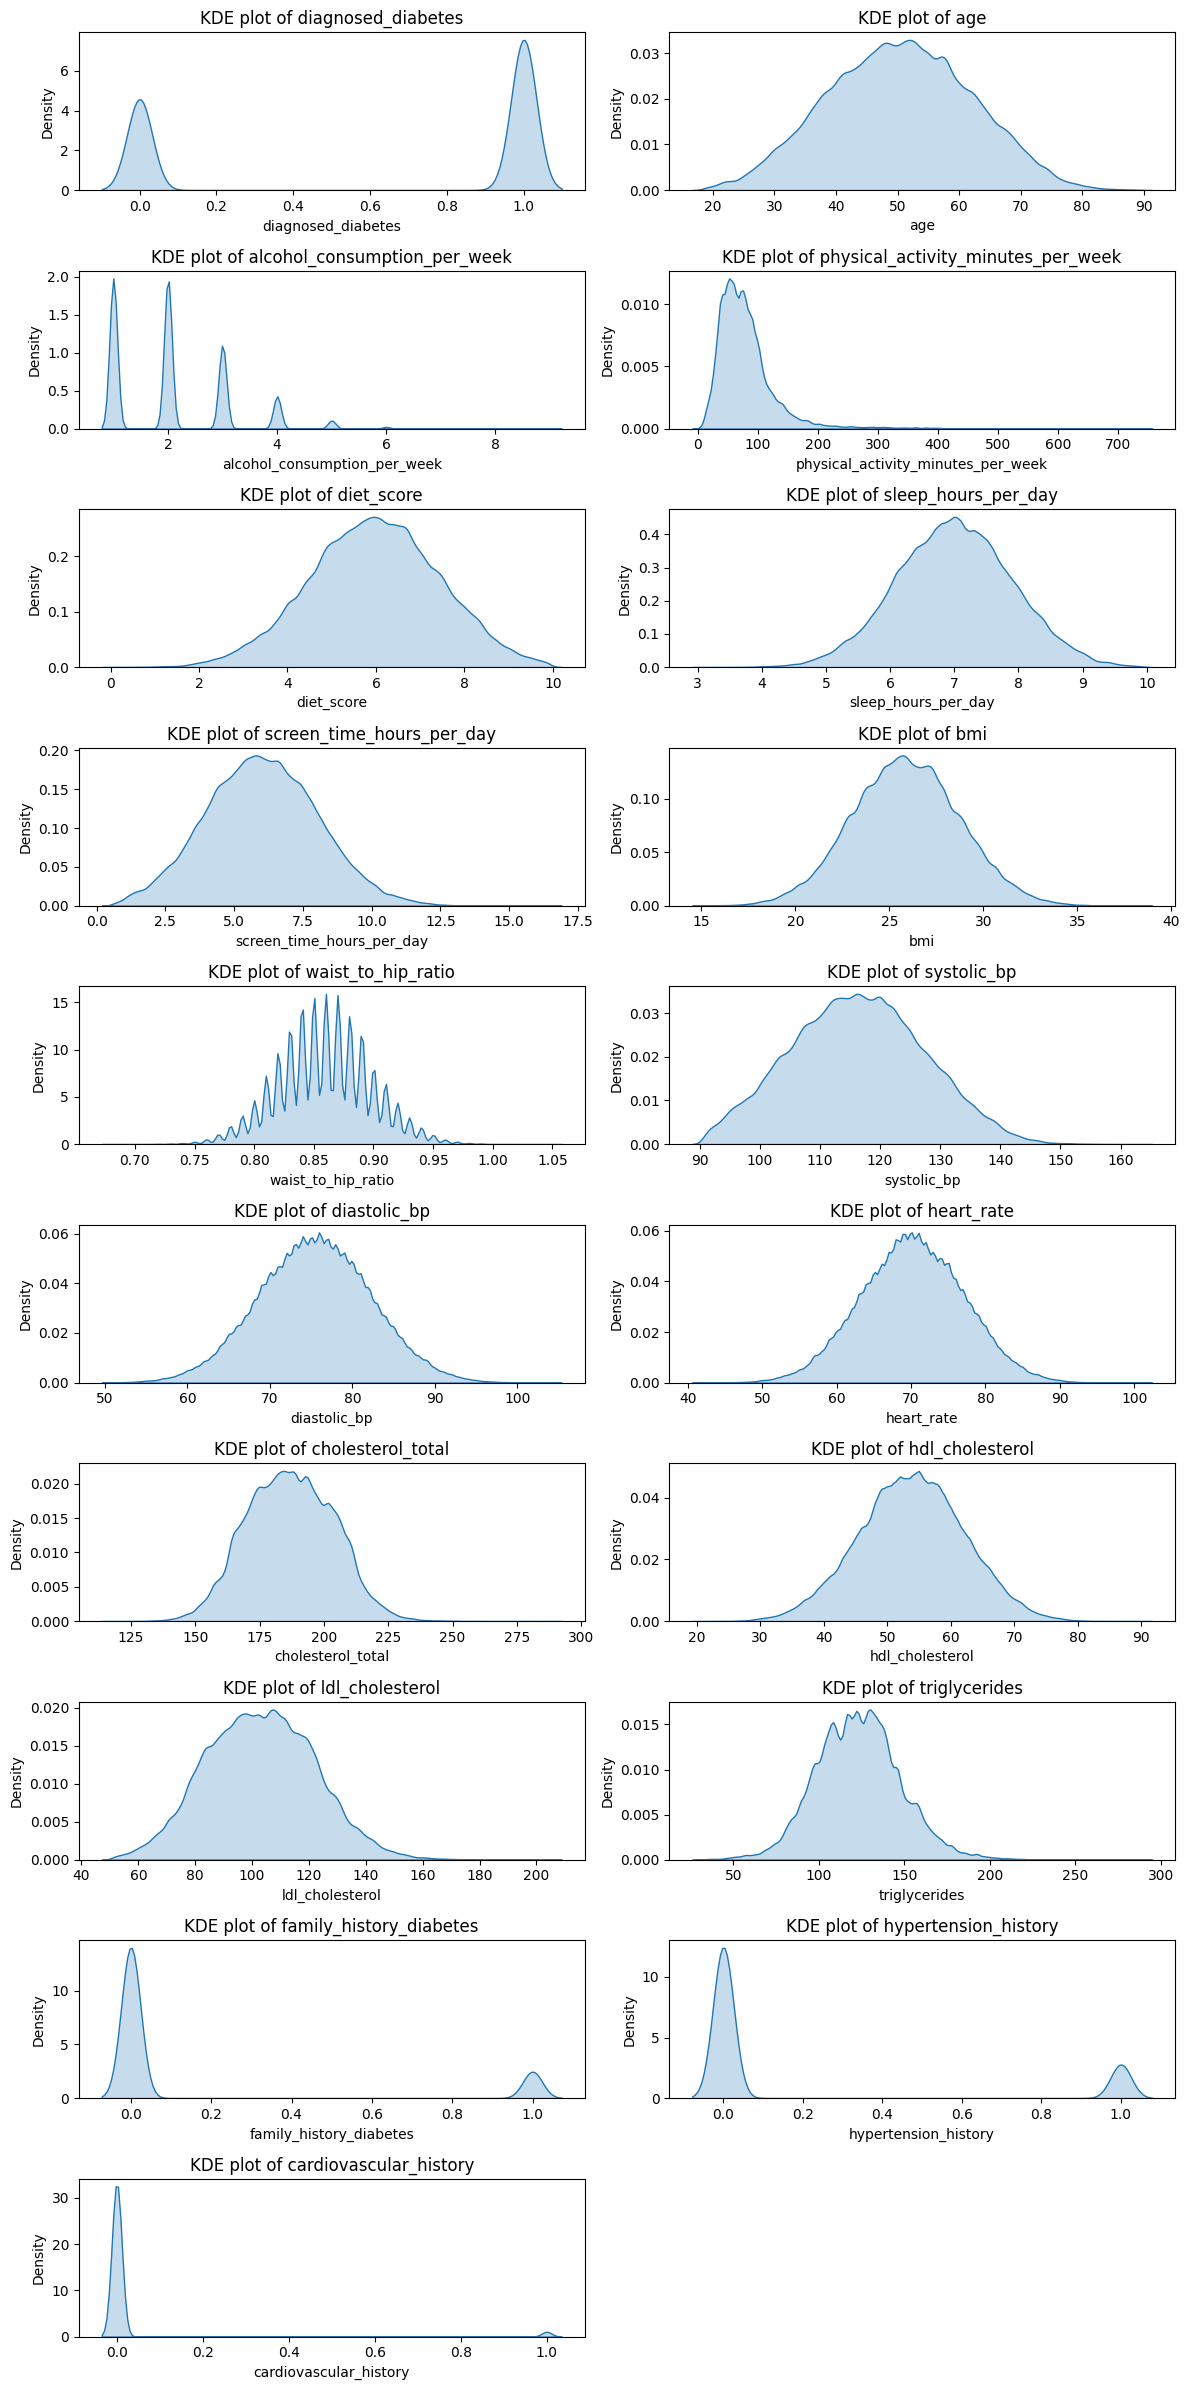

In [9]:
# KDE plots of target variable and numerical features
plt.figure(figsize=(12, 24))
kdeplot_col_names = [target_col]
kdeplot_col_names.extend(numeric_col_names)
for i, col in enumerate(kdeplot_col_names, start=1):
    plt.subplot(10, 2, i)
    sns.kdeplot(data=orig_train_data, x=col, fill=True)
    plt.tight_layout()
    plt.title(f"KDE plot of {col}")

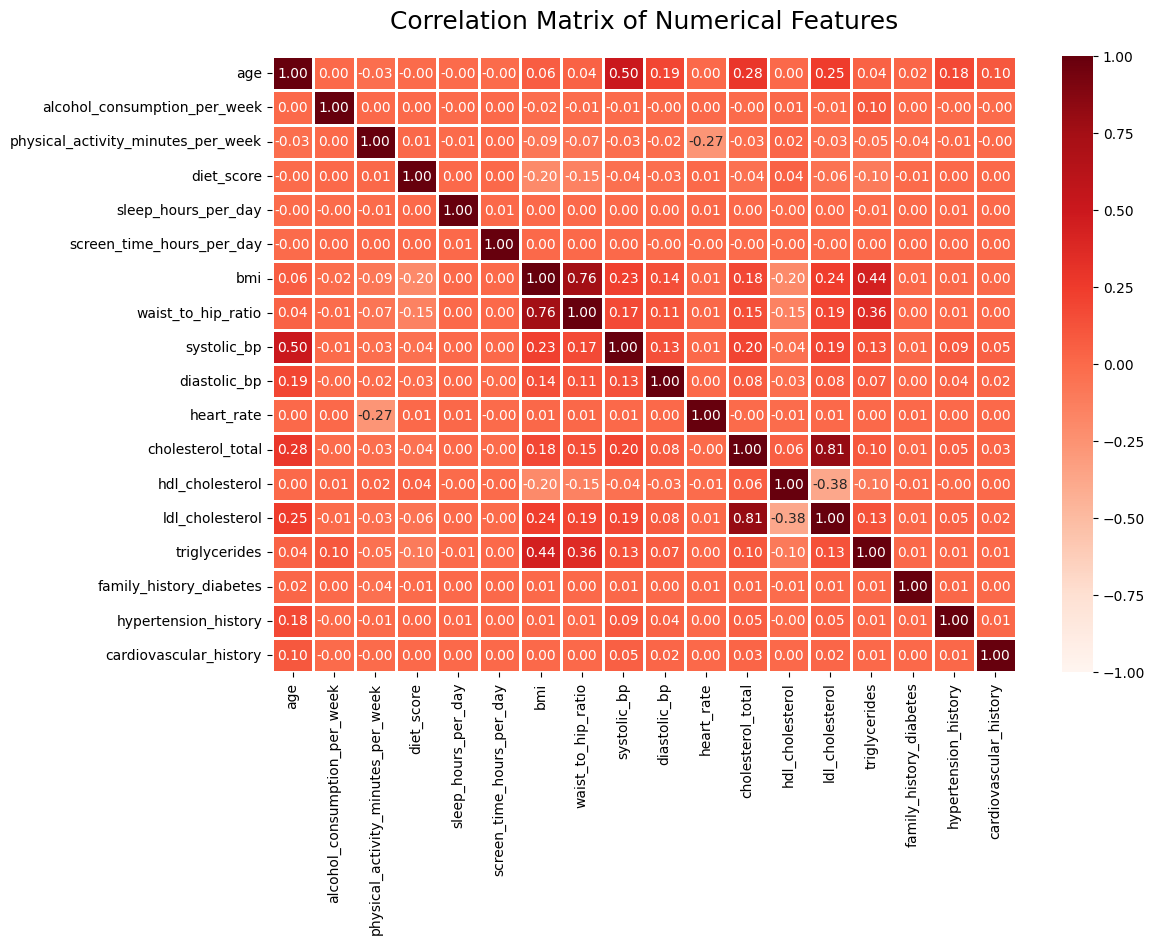

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    orig_train_data[numeric_col_names].corr(),
    cmap='Reds',
    annot=True,
    linewidths=2,
    fmt='.2f',
    vmin=-1,
    vmax=1
)
plt.title('Correlation Matrix of Numerical Features', fontsize=18, pad=20)
plt.show()

# 4. Data Pre-Processing

In [11]:
train_data = orig_train_data.copy()
test_data = orig_test_data.copy()

## 4.1 Ordinal Encoding

In [12]:
# education level
education_level_encoder = OrdinalEncoder(categories=[['No formal', 'Highschool', 'Graduate', 'Postgraduate']])
train_data['education_level_encoded'] = education_level_encoder.fit_transform(train_data[['education_level']])
test_data['education_level_encoded'] = education_level_encoder.fit_transform(test_data[['education_level']])

# income level
income_level_encoder = OrdinalEncoder(categories=[['Low', 'Lower-Middle','Middle', 'Upper-Middle', 'High']])
train_data['income_level_encoded'] = income_level_encoder.fit_transform(train_data[['income_level']])
test_data['income_level_encoded'] = income_level_encoder.fit_transform(test_data[['income_level']])

# smoking status
smoking_status_encoder = OrdinalEncoder(categories=[['Never', 'Former', 'Current']])
train_data['smoking_status_encoded'] = smoking_status_encoder.fit_transform(train_data[['smoking_status']])
test_data['smoking_status_encoded'] = smoking_status_encoder.fit_transform(test_data[['smoking_status']])

# drop original cols
for col in ['income_level', 'education_level', 'smoking_status']:
    train_data.drop(col, axis=1, inplace=True)
    test_data.drop(col, axis=1, inplace=True)

# print out value maps to check assigned values are as expected
for (encoded_col_name, encoder) in [
    ('education_level_encoded', education_level_encoder),
    ('income_level_encoded', income_level_encoder),
    ('smoking_status_encoded', smoking_status_encoder),
]:
    categories = encoder.categories_[0]
    value_map = { category: i for i, category in enumerate(categories) }
    print(f"{encoded_col_name}:\n{value_map}")

education_level_encoded:
{'No formal': 0, 'Highschool': 1, 'Graduate': 2, 'Postgraduate': 3}
income_level_encoded:
{'Low': 0, 'Lower-Middle': 1, 'Middle': 2, 'Upper-Middle': 3, 'High': 4}
smoking_status_encoded:
{'Never': 0, 'Former': 1, 'Current': 2}


## 4.2 Feature Generation

In [13]:
# cholesterol ratio
train_data['cholesterol_ratio'] = train_data['cholesterol_total'] / train_data['hdl_cholesterol']
test_data['cholesterol_ratio'] = test_data['cholesterol_total'] / test_data['hdl_cholesterol']

# pulse pressure
train_data['pulse_pressure'] = train_data['systolic_bp'] - train_data['diastolic_bp']
test_data['pulse_pressure'] = test_data['systolic_bp'] - test_data['diastolic_bp']

# Age x BMI
train_data['age_bmi_interaction'] = train_data['bmi'] * train_data['age']
test_data['age_bmi_interaction'] = test_data['bmi'] * test_data['age']

# 5. Model Training

In [14]:
NUM_SPLITS = 5
skf = StratifiedKFold(n_splits=NUM_SPLITS, shuffle=True, random_state=RANDOM_SEED)
skf_splits = skf.split(train_data.drop(target_col, axis=1), train_data[target_col])
skf_enumeration = enumerate(skf_splits)

In [15]:
cat_features = train_data.drop(target_col, axis=1).select_dtypes(include='object').columns.to_list()
print("##### Categorical features that were not manually encoded #####\n" + "\n".join(cat_features))

##### Categorical features that were not manually encoded #####
gender
ethnicity
employment_status


In [16]:
oof_roc_auc_scores = []
test_preds = np.zeros(len(test_data))

print("##### ROC AUC Scores #####")
for fold, (train_indices, validation_indices) in skf_enumeration:
    X_train_fold = train_data.drop(target_col, axis=1).iloc[train_indices]
    X_validation_fold = train_data.drop(target_col, axis=1).iloc[validation_indices]
    y_train_fold = train_data[target_col].iloc[train_indices]
    y_validation_fold = train_data[target_col].iloc[validation_indices]

    model = CatBoostClassifier(
        iterations=20000,
        learning_rate=0.01,
        depth=6,
        use_best_model=True,
        cat_features=cat_features,
        eval_metric='AUC',
        task_type='GPU' if torch.cuda.is_available() else 'CPU',
        devices='0',
        random_seed=RANDOM_SEED,
        verbose=False
    )

    model.fit(X_train_fold, y_train_fold, eval_set=(X_validation_fold, y_validation_fold))
    y_validation_pred_proba = model.predict_proba(X_validation_fold)[:, 1]
    roc_auc_score_fold = roc_auc_score(y_validation_fold, y_validation_pred_proba)
    oof_roc_auc_scores.append(roc_auc_score_fold)
    print(f"Fold {fold + 1}: {roc_auc_score_fold}")

    y_test_pred_proba = model.predict_proba(test_data)[:, 1]
    test_preds += np.array(y_test_pred_proba) / NUM_SPLITS

print("-----")
print(f"Average score over all folds: {np.mean(oof_roc_auc_scores)}")

##### ROC AUC Scores #####


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1: 0.7228724788331996


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2: 0.7240750620388637


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3: 0.7291174049138898


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4: 0.7268908861978265


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5: 0.7258575239227234
-----
Average score over all folds: 0.7257626711813006


# 6. Submission

In [17]:
# prepare submission
submission = pd.DataFrame({'id': test_data.index, target_col: test_preds})
submission.to_csv('submission.csv', index=False)
print('Submission file prepared.')

Submission file prepared.
